In [1]:
import time
import gym
import numpy as np
import control as ct
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import os
tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
def split_forward_filter_fn(A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,z):
    '''Calculates prior distribution based on the previous posterior distribution
        and the current residual updates posterior distribution based on the new
        prior distribution
    '''
#     print('z',z)
#     print('A', A)
#     print('B',B)
#     print('u',u)
#     print('g',g)
#     print('sigma',sigma)
#     print('C', C)
#     print('l_a_posteriori', l_a_posteriori)
#     print('P_a_posteriori', P_a_posteriori)
    _I = tf.eye(int(A.shape[0]), dtype = tf.float64)
    
    z = tf.expand_dims(z,-1)
    l_a_priori = tf.matmul(A,l_a_posteriori) + tf.matmul(B,u)
#     print('l_a_priori',l_a_priori)
    P_a_priori = tf.matmul(tf.matmul(A,P_a_posteriori), A, transpose_b = True) + tf.matmul(g,g, transpose_b=True)
#     print('P_a_priori',P_a_priori)
    y_pre = z - tf.matmul(C,l_a_priori)
#     print('y_pre', y_pre)
    S = tf.square(sigma) + tf.matmul(tf.matmul(C, P_a_priori), C, transpose_b=True)
#     print('S',S)
    S_inv = tf.math.reciprocal(S)
#     print('S_inv', S_inv)
    K = tf.matmul(tf.matmul(P_a_priori, C, transpose_b=True), S_inv)
#     print('K', K)
    l_a_posteriori = l_a_priori + tf.matmul(K,y_pre)
#     print('l_a_posteriori', l_a_posteriori)
    I_KC = _I-tf.matmul(K,C)
#     print('I-KC', I_KC)
    P_a_posteriori = tf.matmul(tf.matmul(I_KC, P_a_priori), I_KC, transpose_b=True) + \
                        tf.matmul(tf.matmul(K,tf.matmul(sigma, sigma, transpose_b = True)),
                                K, transpose_b=True)
#     print('P_a_posteriori',P_a_posteriori)
    y_post = z-tf.matmul(C,l_a_posteriori)
    squared_error = tf.squeeze(tf.matmul(y_post,y_post, transpose_a=True))
#     print(squared_error)
#     print('y_post', y_post)
    pred = tf.matmul(C, l_a_posteriori)
#     print('pred', pred)
        
    return l_a_posteriori,P_a_posteriori,z, pred, squared_error

In [3]:
class split_KF_Model(object):
    def __init__(self, initial_state_variation = [0,0,0,0], control = False):
        self.m = 4
        self.dim_z = self.m
        self.n = 4
        self.r = 1
        self.lstm_input_dim = self.m+4
        self.sigma_upper_bound = 0.1
        self.sigma_lower_bound = 0
        self.g_upper_bound = 1
        self.g_lower_bound = 0.1
        self.mu_0_upper_bound = 1
        self.mu_0_lower_bound = 0
        self.Sigma_0_upper_bound = 1
        self.Sigma_0_lower_bound = 0
        self.weight_beta = 10
        self.bias_beta = 10
        thetaacc_error = 0
        self.global_epoch = 0
        
        '''Temporary LQR variables'''
        self.Q = np.eye(4)*[1,1,1,1]
        self.R = 10
        self.u_clip_value = tf.Variable(20, dtype = tf.float64, trainable = False)

        self.initial_variance_estimate = tf.Variable(np.array([[1]]), dtype = tf.float64, trainable=False) 

        self.lstm_sizes = [128,64]
        self.env = gym.make('Custom_CartPole-v0', thetaacc_error=thetaacc_error, initial_state_variation=initial_state_variation)
        gravity = self.env.gravity
        cart_mass = self.env.masscart
        pole_mass = self.env.masspole
        pole_length = self.env.length
        self.env_params = tf.expand_dims(np.array([gravity, cart_mass,pole_mass,pole_length],
                                             dtype=np.float64),0)
        self.control = control
        self.variables = []
        
    def build_LSTM(self):
        lstms = [tf.contrib.rnn.LSTMCell(size, reuse=tf.get_variable_scope().reuse) for size in self.lstm_sizes]
        dropouts = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = 0.5) for lstm in lstms]

        self.cell = tf.contrib.rnn.MultiRNNCell(dropouts)
#         print(self.cell.trainable_variables)
#         print(self.cell.trainable_weights)
#         self.variables.append(self.cell.trainable_variables)
        return self
    
    def get_variables(self):
        return self.variables
    def reset_variables(self):
        self.variables = []
        return self
    def set_control(self, control):
        self.control = control
        return self
    
    def likelihood_fn(self, params, inputs):
        A, B, u, g, C, sigma, l_filtered, P_filtered = inputs
        mu_1, Sigma_1 = params
#         print('A',len(A))
#         print('B',len(B))
#         print('u',len(u))
#         print('C',len(C))
#         print('g',len(g))
#         print('sigma',len(sigma))
#         print('l_filtered',len(l_filtered))
#         print('p_filtered',len(P_filtered))
#         print('mu_1',mu_1.shape)
#         print('Sigma_1',Sigma_1.shape)
        mu = [mu_1]
        Sigma = [Sigma_1]
        assert(len(A)==len(B) and len(B)==len(u) and len(u)==len(sigma) and 
               len(sigma)==len(l_filtered) and len(l_filtered)==len(P_filtered)),"Not all sequences are same length"
        for i in range(len(A)):
            mu.append(tf.matmul(C, tf.add(tf.matmul(A[i],l_filtered[i]), tf.matmul(B[i],u[i]))))
            temp = tf.matmul(tf.matmul(A[i], P_filtered[i]), A[i], transpose_b=True) + \
                        tf.matmul(g[i], g[i], transpose_b=True)
            Sigma.append(tf.matmul(tf.matmul(C, temp), C, transpose_b=True) + \
                        tf.matmul(sigma[i],sigma[i],transpose_b=True))
        return mu,Sigma
    
    def __call__(self, view = False):
        self.reset_variables()
        rewards = 0
        A_all = []
        B_all = []
        u_all = []
        g_all = []
        C_1 = tf.Variable(np.array([[1,0,0,0]]), dtype = tf.float64, trainable=False)
        C_2 = tf.Variable(np.array([[0,1,0,0]]), dtype = tf.float64, trainable=False)
        C_3 = tf.Variable(np.array([[0,0,1,0]]), dtype = tf.float64, trainable=False)
        C_4 = tf.Variable(np.array([[0,0,0,1]]), dtype = tf.float64, trainable=False)
        sigma1_all = []
        sigma2_all = []
        sigma3_all = []
        sigma4_all = []
        l_a_posteriori1 = []
        l_a_posteriori2 = []
        l_a_posteriori3 = []
        l_a_posteriori4 = []
        P_a_posteriori1 = []
        P_a_posteriori2 = []
        P_a_posteriori3 = []
        P_a_posteriori4 = []
        env_states1 = []
        env_states2 = []
        env_states3 = []
        env_states4 = []
        preds1 = []
        preds2 = []
        preds3 = []
        preds4 = []
        squared_error1 = []
        squared_error2 = []
        squared_error3 = []
        squared_error4 = []
        rbf = []
#         all_KF_params = [A_all,B_all,u_all,g_all,C_all,sigma1_all,sigma2_all,sigma3_all,sigma4_all,
#                          l_a_posteriori1,l_a_posteriori2,l_a_posteriori3,l_a_posteriori4,
#                          P_a_posteriori1,P_a_posteriori2,P_a_posteriori3,P_a_posteriori4,
#                          env_states,preds,squared_error,rbf]
        KF1_params = [l_a_posteriori1,P_a_posteriori1,env_states1, preds1, squared_error1]
        KF2_params = [l_a_posteriori2,P_a_posteriori2,env_states2, preds2, squared_error2]
        KF3_params = [l_a_posteriori3,P_a_posteriori3,env_states3, preds3, squared_error3]
        KF4_params = [l_a_posteriori4,P_a_posteriori4,env_states4, preds4, squared_error4]

        '''p-quantile loss'''
        Q50_numerator = np.zeros(4)
        Q90_numerator = np.zeros(4)
        
        '''Build LSTM'''
        self.build_LSTM()
        
        '''Start gym environment'''
        observation=self.env.reset()

        '''Get initial lstm state and input, get first output/state'''
        initial_state = self.cell.get_initial_state(batch_size=1,dtype = tf.float64)
        initial_input = tf.concat((self.env_params,
                                   tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),0)),
                                  axis=1)
#         initial_input = tf.concat((self.env_params, np.zeros(shape=(1,4)),axis=1)
        output_single, state_single = self.cell(inputs=initial_input, state=initial_state)
        if not self.control:
            self.variables.extend(self.cell.trainable_variables)

#         print('LSTM cell trainable',len(self.cell.trainable_variables))
#         print('Rewards', self.rewards)
#         print('VARIABLES',[x.name for x in self.cell.trainable_variables])
#         print('\n\n\nWEIGHTS',[x.name for x in self.cell.trainable_weights])

        '''Calculate mu_0,Sigma_0, distribution using initial LSTM output'''
        container = tf.contrib.eager.EagerVariableStore()
        control_container = tf.contrib.eager.EagerVariableStore()
        with container.as_default():
            mu_0 = tf.layers.dense(output_single, self.m, kernel_regularizer = reg.l1(self.weight_beta),
                                       bias_regularizer = reg.l2(self.bias_beta),
                                       name = 'mu_0dense', reuse = True)
            Sigma_0 = tf.layers.dense(output_single, self.m, kernel_regularizer = reg.l1(self.weight_beta),
                                          bias_regularizer = reg.l2(self.bias_beta),
                                          name = 'Sigma_0dense', reuse = True)
        mu_0 = tf.reshape(mu_0, shape = (self.m,1))
        mu_0 = ((self.mu_0_upper_bound-self.mu_0_lower_bound)/(1+tf.exp(-mu_0)))+self.mu_0_lower_bound

        Sigma_0 = tf.reshape(Sigma_0, shape = (self.m,1))
        Sigma_0 = tf.matmul(Sigma_0,Sigma_0,transpose_b=True)+tf.eye(4, dtype=tf.float64)*1e-8

        l_0_dist = tfd.MultivariateNormalFullCovariance(loc = tf.squeeze(mu_0),
                                                                covariance_matrix= Sigma_0,
                                                                validate_args=True)
        l_0 = tf.expand_dims(l_0_dist.sample(),1)
        l_a_posteriori1.append(l_0)
        l_a_posteriori2.append(l_0)
        l_a_posteriori3.append(l_0)
        l_a_posteriori4.append(l_0)
        P_a_posteriori1.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)
        P_a_posteriori2.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)
        P_a_posteriori3.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)
        P_a_posteriori4.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)

        first_pass = True
        done = False
        while not done:
            if view:
                self.env.render()
            '''Get lstm outputs'''
            with container.as_default():
                A = tf.layers.dense(output_single, self.m*self.n, kernel_regularizer = reg.l1(self.weight_beta),
                                    bias_regularizer = reg.l2(self.bias_beta),
                                    name = 'A_dense', reuse = True)

                g = tf.layers.dense(output_single, self.m, kernel_regularizer = reg.l1(self.weight_beta),
                                    bias_regularizer = reg.l2(self.bias_beta),
                                    name = 'g_dense', reuse = True)
                sigma1 = tf.layers.dense(output_single, 1, kernel_regularizer = reg.l1(self.weight_beta),
                                        bias_regularizer = reg.l2(self.bias_beta),
                                        name = 'sigma1_dense', reuse = True)
                sigma2 = tf.layers.dense(output_single, 1, kernel_regularizer = reg.l1(self.weight_beta),
                                        bias_regularizer = reg.l2(self.bias_beta),
                                        name = 'sigma2_dense', reuse = True)
                sigma3 = tf.layers.dense(output_single, 1, kernel_regularizer = reg.l1(self.weight_beta),
                                        bias_regularizer = reg.l2(self.bias_beta),
                                        name = 'sigma3_dense', reuse = True)
                sigma4 = tf.layers.dense(output_single, 1, kernel_regularizer = reg.l1(self.weight_beta),
                                        bias_regularizer = reg.l2(self.bias_beta),
                                        name = 'sigma4_dense', reuse = True)
            if self.control:
                with control_container.as_default():
                    B = tf.layers.dense(output_single, self.m*self.r, kernel_regularizer = reg.l1(self.weight_beta),
                                        bias_regularizer = reg.l2(self.bias_beta),
                                        name = 'B_dense', reuse = True)
            '''If this is first pass in loop, add variables to graph'''
            if first_pass and not self.control:
                self.variables.extend(container.trainable_variables())
                first_pass = False
            elif first_pass and self.control:
                self.variables.extend(control_container.trainable_variables())
                first_pass = False
            '''Reshape and transform variables'''
            A = tf.reshape(A, shape = (self.m,self.n))
            if self.control:
                B = tf.reshape(B, shape = (self.m,self.r))
            else:
                B = tf.zeros(shape = (self.m,self.r), dtype = tf.float64)
            g = tf.reshape(g, shape = (self.m, 1))
            g = ((self.g_upper_bound-self.g_lower_bound)/(1+tf.exp(-g)))+self.g_lower_bound
#             sigma = tf.reshape(sigma, shape = (self.dim_z,1))
            sigma1 = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma1)))+self.sigma_lower_bound
            sigma2 = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma2)))+self.sigma_lower_bound
            sigma3 = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma3)))+self.sigma_lower_bound
            sigma4 = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma4)))+self.sigma_lower_bound
            
            if self.control:
                K,S,E = ct.lqr(A.numpy(),B.numpy(),self.Q,self.R)
                u = -tf.matmul(K.astype(np.float64),tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),-1))
                u = tf.clip_by_value(u, -self.u_clip_value, self.u_clip_value)
            else:
                u = tf.zeros(shape = [1,self.r], dtype=tf.float64)
#             C = tf.eye(self.dim_z, dtype = tf.float64)
            observation, reward, done, info = self.env.step(tf.squeeze(u))
#             print(observation.shape)
            '''Calculate:
                A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,env_states'''
#             KF_update = split_forward_filter_fn(A, B, u,g, C, sigma,l_a_posteriori[-1],P_a_posteriori[-1],
#                                           tf.convert_to_tensor(observation,dtype=tf.float64))
            KF1_update = split_forward_filter_fn(A,B,u,g,C_1,sigma1,l_a_posteriori1[-1],P_a_posteriori1[-1],
                                                tf.expand_dims(tf.convert_to_tensor(observation[0],dtype=tf.float64),-1))
            KF2_update = split_forward_filter_fn(A,B,u,g,C_2,sigma2,l_a_posteriori2[-1],P_a_posteriori2[-1],
                                                tf.expand_dims(tf.convert_to_tensor(observation[1],dtype=tf.float64),-1))
            KF3_update = split_forward_filter_fn(A,B,u,g,C_3,sigma3,l_a_posteriori3[-1],P_a_posteriori3[-1],
                                                tf.expand_dims(tf.convert_to_tensor(observation[2],dtype=tf.float64),-1))
            KF4_update = split_forward_filter_fn(A,B,u,g,C_4,sigma4,l_a_posteriori4[-1],P_a_posteriori4[-1],
                                                tf.expand_dims(tf.convert_to_tensor(observation[3],dtype=tf.float64),-1))
            A_all.append(A)
            B_all.append(B)
            u_all.append(u)
            g_all.append(g)
            sigma1_all.append(sigma1)
            sigma2_all.append(sigma2)
            sigma3_all.append(sigma3)
            sigma4_all.append(sigma4)

            '''Update lists:
                A_all,B_all,u_all,g_all,C_all,sigma_all,l_a_posteriori,P_a_posteriori,env_states'''
#             for KF_single,KF_param  in zip(KF_update,all_KF_params):
#                 KF_param.append(KF_single)
            for KF_single,KF_param in zip(KF1_update,KF1_params):
                KF_param.append(KF_single)
            for KF_single,KF_param in zip(KF2_update,KF2_params):
                KF_param.append(KF_single)
            for KF_single,KF_param in zip(KF3_update,KF3_params):
                KF_param.append(KF_single)
            for KF_single,KF_param in zip(KF4_update,KF4_params):
                KF_param.append(KF_single)
                
            rewards+=1
            next_input = tf.concat((self.env_params,env_states1[-1],env_states2[-1],
                                    env_states3[-1],env_states4[-1]),axis=1)
            output_single,state_single=self.cell(inputs=next_input,state=state_single)
        if view:
            self.env.close()

#         param_names = ['A_all','B_all','u_all','g_all','C_all','sigma_all',
#                        'l_a_posteriori','P_a_posteriori','env_states','preds']
#             for name,KF_param in zip(param_names,all_KF_params):
#                 print(name,len(KF_param), KF_param[0].shape)

#         print('mu_0',mu_0)
#         print('Sigma_0',Sigma_0)
#         print('A_all',A_all[0])
#         print('B_all',B_all[0])
#         print('u_all',u_all[0])
#         print('C_1',C_1)
#         print('sigma1_all',sigma1_all[0])

        mu_11 = tf.add(tf.matmul(tf.slice(A_all[0],(0,0),(1,4)), mu_0),tf.matmul(tf.slice(B_all[0],(0,0),(1,1)),u_all[0]))
        Sigma_11 = tf.add(tf.matmul(tf.matmul(C_1,Sigma_0),C_1, transpose_b=True),
                     tf.matmul(sigma1_all[0],sigma1_all[0],transpose_b=True))
        mu_12 = tf.add(tf.matmul(tf.slice(A_all[0],(1,0),(1,4)), mu_0),tf.matmul(tf.slice(B_all[0],(1,0),(1,1)),u_all[0]))
        Sigma_12 = tf.add(tf.matmul(tf.matmul(C_2,Sigma_0),C_2, transpose_b=True),
                     tf.matmul(sigma2_all[0],sigma2_all[0],transpose_b=True))
        mu_13 = tf.add(tf.matmul(tf.slice(A_all[0],(2,0),(1,4)), mu_0),tf.matmul(tf.slice(B_all[0],(2,0),(1,1)),u_all[0]))
        Sigma_13 = tf.add(tf.matmul(tf.matmul(C_3,Sigma_0),C_3, transpose_b=True),
                     tf.matmul(sigma3_all[0],sigma3_all[0],transpose_b=True))
        mu_14 = tf.add(tf.matmul(tf.slice(A_all[0],(3,0),(1,4)), mu_0),tf.matmul(tf.slice(B_all[0],(3,0),(1,1)),u_all[0]))
        Sigma_14 = tf.add(tf.matmul(tf.matmul(C_4,Sigma_0),C_4, transpose_b=True),
                     tf.matmul(sigma4_all[0],sigma4_all[0],transpose_b=True))
#         print('mu_11',mu_11)
#         print('Sigma_11',Sigma_11)
        if rewards > 1:
            mu1,Sigma1 = self.likelihood_fn((mu_11,Sigma_11),(A_all[1:],B_all[1:],u_all[1:],g_all[1:],
                                                     C_1,sigma1_all[1:],
                                                     l_a_posteriori1[1:-1],
                                                     P_a_posteriori1[1:-1]))
            mu2,Sigma2 = self.likelihood_fn((mu_12,Sigma_12),(A_all[1:],B_all[1:],u_all[1:],g_all[1:],
                                                     C_2,sigma2_all[1:],
                                                     l_a_posteriori2[1:-1],
                                                     P_a_posteriori2[1:-1]))
            mu3,Sigma3 = self.likelihood_fn((mu_13,Sigma_13),(A_all[1:],B_all[1:],u_all[1:],g_all[1:],
                                                     C_3,sigma3_all[1:],
                                                     l_a_posteriori3[1:-1],
                                                     P_a_posteriori3[1:-1]))
            mu4,Sigma4 = self.likelihood_fn((mu_14,Sigma_14),(A_all[1:],B_all[1:],u_all[1:],g_all[1:],
                                                     C_4,sigma4_all[1:],
                                                     l_a_posteriori4[1:-1],
                                                     P_a_posteriori4[1:-1]))

        '''p-quantile loss'''
        for j in range(rewards):
            Q50_numerator[0] += QL(0.5, preds1[j], env_states1[j])
            Q90_numerator[0] += QL(0.9, preds1[j], env_states1[j])
        for j in range(rewards):
            Q50_numerator[1] += QL(0.5, preds2[j], env_states2[j])
            Q90_numerator[1] += QL(0.9, preds2[j], env_states2[j])
        for j in range(rewards):
            Q50_numerator[2] += QL(0.5, preds3[j], env_states3[j])
            Q90_numerator[2] += QL(0.9, preds3[j], env_states3[j])
        for j in range(rewards):
            Q50_numerator[3] += QL(0.5, preds4[j], env_states4[j])
            Q90_numerator[3] += QL(0.9, preds4[j], env_states4[j])

        Q_denomenator1 = np.sum(np.abs(np.squeeze(np.array(env_states1))), axis = 0)
        Q_denomenator2 = np.sum(np.abs(np.squeeze(np.array(env_states2))), axis = 0)
        Q_denomenator3 = np.sum(np.abs(np.squeeze(np.array(env_states3))), axis = 0)
        Q_denomenator4 = np.sum(np.abs(np.squeeze(np.array(env_states4))), axis = 0)
#         for idx,slot in enumerate(Q_denomenator):
#             if slot==0:
#                 Q_denomenator[idx]+=np.abs(np.random.normal(loc = 0.0, scale = 1e-10))
        pq50_loss1 = 2*np.divide(Q50_numerator[0],Q_denomenator1)
        pq90_loss1 = 2*np.divide(Q90_numerator[0],Q_denomenator1)
        pq50_loss2 = 2*np.divide(Q50_numerator[1],Q_denomenator2)
        pq90_loss2 = 2*np.divide(Q90_numerator[1],Q_denomenator2)
        pq50_loss3 = 2*np.divide(Q50_numerator[2],Q_denomenator3)
        pq90_loss3 = 2*np.divide(Q90_numerator[2],Q_denomenator3)
        pq50_loss4 = 2*np.divide(Q50_numerator[3],Q_denomenator4)
        pq90_loss4 = 2*np.divide(Q90_numerator[3],Q_denomenator4)

        
        '''Compute Likelihood of observations given KF evaluation'''
        z1_distribution = tfd.Normal(loc = mu1, scale = Sigma1)
        z1_likelihood = z1_distribution.log_prob(env_states1)
        z2_distribution = tfd.Normal(loc = mu2, scale = Sigma2)
        z2_likelihood = z2_distribution.log_prob(env_states2)
        z3_distribution = tfd.Normal(loc = mu3, scale = Sigma3)
        z3_likelihood = z3_distribution.log_prob(env_states3)
        z4_distribution = tfd.Normal(loc = mu4, scale = Sigma4)
        z4_likelihood = z4_distribution.log_prob(env_states4)
        self.global_epoch += 1
        if self.global_epoch%50 == 0:
            print(np.min(np.array(u_all)))
            print(np.max(np.array(u_all)))
        return((z1_likelihood,z2_likelihood,z3_likelihood,z4_likelihood), rewards, (preds1,preds2,preds3,preds4), (env_states1,env_states2,env_states3,env_states4),
               (squared_error1,squared_error2,squared_error3,squared_error4), (pq50_loss1,pq90_loss1,pq50_loss2,pq90_loss2,pq50_loss3,pq90_loss3,pq50_loss4,pq90_loss4))

def QL(rho, z, z_pred):
    if z > z_pred:
        return rho*(z-z_pred)
    else:
        return (1-rho)*(z_pred-z)
    
def standard_loss(model,view):
    likelihoods, rewards, preds, trajectory, squared_error, pq_loss = model(view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for likelihood in likelihoods:
        for loss_term in likelihood:
            loss = tf.add(loss,-loss_term)
    return loss, rewards, preds, trajectory, squared_error, pq_loss

def inverse_multiplicative_loss(model,view):
    '''This gives loss terms which are a multiple of their time step'''
    likelihoods, rewards, preds, trajectory, squared_error, pq_loss = model(view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for likelihood in likelihoods:
        for t,loss_term in enumerate(likelihood):
            loss = tf.add(loss,-(loss_term*(1/(t+1))))
    return loss, rewards, preds, trajectory, squared_error, pq_loss

def multiplicative_loss(model,view):
    '''This gives loss terms which are a multiple of their time step'''
    likelihoods, rewards, preds, trajectory, squared_error, pq_loss = model(view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for likelihood in likelihoods:
        for t,loss_term in enumerate(likelihood):
            loss = tf.add(loss,-(loss_term*t))
    return loss, rewards, preds, trajectory, squared_error, pq_loss

def exponential_loss(model, alpha,view):
    '''For alpha > 1 this gives exponentially increasing loss
        For 0<alpha<1 this gives discounted loss'''
    likelihoods, rewards, preds, trajectory, squared_error, pq_loss = model(view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for likelihood in likelihoods:
        for t,loss_term in enumerate(likelihood):
            loss = tf.add(loss,-(tf.math.pow(alpha,t)*loss_term))
    return loss, rewards, preds, trajectory, squared_error, pq_loss
    

def compute_gradient(model, loss_type, alpha,view = False):
    with tf.GradientTape() as tape:
        if loss_type == 'standard':
            loss_value, rewards, preds,trajectory, squared_error, pq_loss = standard_loss(model,view)
        elif loss_type == 'inverse_multiplicative':
            loss_value, rewards, preds,trajectory, squared_error, pq_loss = inverse_multiplicative_loss(model,view)
        elif loss_type == 'multiplicative':
            loss_value, rewards, preds,trajectory, squared_error, pq_loss = multiplicative_loss(model,view)
        elif loss_type == 'exponential':
            loss_value, rewards, preds,trajectory, squared_error, pq_loss = exponential_loss(model, tf.convert_to_tensor(alpha, dtype = tf.float64),view)
#         print(tape.gradient(loss_value,epoch.get_variables()))
#         print(len(tape.watched_variables()))
#         for var in tape.watched_variables():
#               print(var.name)
    return (tape.gradient(loss_value, model.get_variables()), loss_value.numpy(),rewards, preds, trajectory, squared_error, pq_loss)

In [4]:
def train(model, num_epochs, optimizer, loss_type='standard', alpha = None, view_rate = False):
    start = time.time()
    for i in range(num_epochs):
        if view_rate:
            if (model.global_epoch+1)%view_rate==0:
                grads, loss_, reward_, pred, trajectory,squared_error, pq_loss = compute_gradient(model, loss_type, alpha, view=True)
            else:
                grads, loss_, reward_, pred, trajectory,squared_error, pq_loss = compute_gradient(model, loss_type, alpha)
        else:
            grads, loss_, reward_, pred, trajectory,squared_error, pq_loss = compute_gradient(model, loss_type, alpha)
        
        '''Keep track of loss, rewards, etc.'''
        losses.extend(loss_)
        rewards.append(reward_)
        predicted_trajectories.append(pred)
        actual_trajectories.append(trajectory)
        squared_errors.append(squared_error)
        pq_losses.append(pq_loss)
#         rbfs.append(rbf)
#         for idx, grad in enumerate(grads):
#             grad_norms[idx].append(np.linalg.norm(grad))
            
        '''clip gradients'''
#         clipped_grads = [tf.clip_by_value(grad_, -1.,1.) for grad_ in grads]
#         clipped_grads = [tf.clip_by_norm(grad, 1.) for grad in grads]
        
        
        '''Apply the gradient update to variables'''
#         optimizer.apply_gradients(zip(clipped_grads,model.get_variables()))
        optimizer.apply_gradients(zip(grads,model.get_variables()))

        
        if (model.global_epoch+1)%50 == 0:
            print('Epoch {}'.format(model.global_epoch+1))
            print('Minutes elapsed: {}'.format((time.time()-start)/60))
            print('Last 50 averages: Loss: {}, reward: {}, loss/reward: {}'.format(np.mean(losses[-50:]), np.mean(rewards[-50:]),(np.mean(losses[-50:])/np.mean(rewards[-50:]))))
#             print('Model variables:')
#             for var in model.get_variables():
#                 print(var.name)
            print()

In [5]:
split_model = split_KF_Model(initial_state_variation=[0,0,0.1,0])
optimizer = tf.train.AdamOptimizer()
losses = []
rewards = []
pq_losses = []
model_vars = ['A_dense/bias:0', 'A_dense/kernel:0', 'B_dense/bias:0', 'B_dense/kernel:0',
              'Sigma_0dense/bias:0', 'Sigma_0dense/kernel:0', 'g_dense/bias:0', 'g_dense/kernel:0',
              'mu_0dense/bias:0', 'mu_0dense/kernel:0', 'sigma_dense/bias:0', 'sigma_dense/kernel:0',
              'multi_rnn_cell/cell_0/lstm_cell/kernel:0', 'multi_rnn_cell/cell_0/lstm_cell/bias:0',
              'multi_rnn_cell/cell_1/lstm_cell/kernel:0', 'multi_rnn_cell/cell_1/lstm_cell/bias:0']
grad_norms = [[var] for var in model_vars]
predicted_trajectories = []
actual_trajectories = []
squared_errors = []
rbfs = []

In [6]:
train(split_model,100,tf.train.AdamOptimizer())
split_model.set_control(True)
train(split_model,500,tf.train.AdamOptimizer(), 'exponential', alpha = 0.9, view_rate=25)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Epoch 50
Minutes elapsed: 1.3908139626185099
Last 50 averages: Loss: 3143.447838635252, reward: 51.326530612244895, loss/reward: 61.24411295949398

0.0
0.0
Epoch 100
Minutes elapsed: 2.79634378751119
Last 50 averages: Loss: 2446.4432194923215, reward: 49.16, loss/reward: 49.7649149611945

0.0
0.0
Epoch 150
Minutes elapsed: 1.5838961243629455
Last 50 averages: Loss: 4212.763782078988, reward: 50.22, loss/reward: 83.88617646513318

-12.484972319233451
13.533818149926493
Epoch 200
Minutes elapsed: 3.1949512004852294
Last 50 averages: Loss: 4195.901665167781, reward: 49.48, loss/reward: 84.79995281260

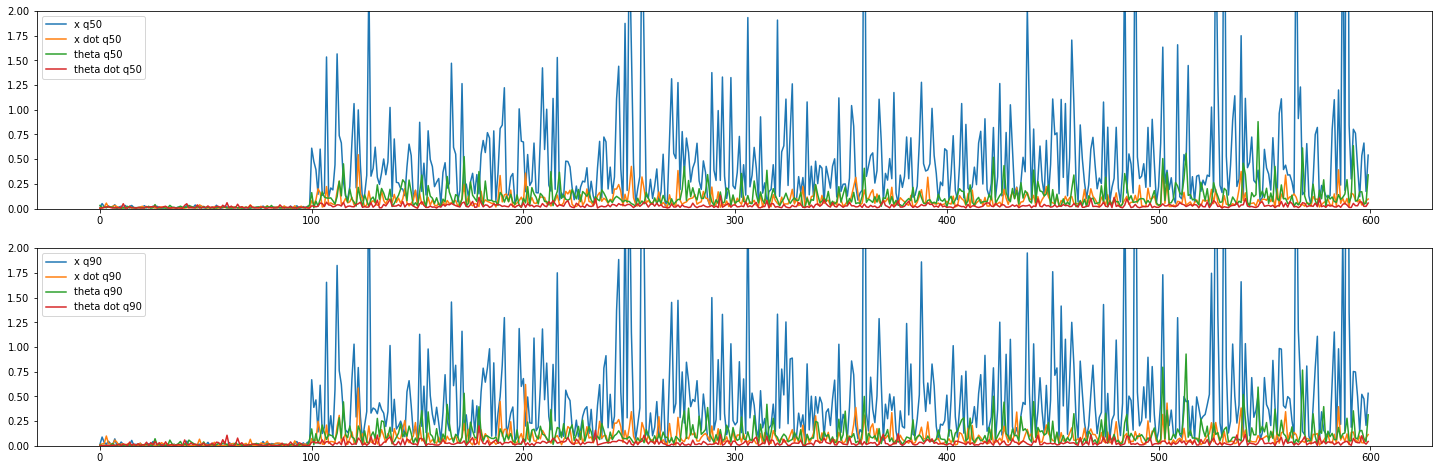

In [9]:
array_pq_losses = np.array(pq_losses).T
labels = ['x q50','x q90','x dot q50','x dot q90','theta q50','theta q90','theta dot q50','theta dot q90']
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (25,8))
for i in range(array_pq_losses.shape[0]):
    if i%2 == 0:
        ax1.plot(array_pq_losses[i], label = labels[i])
    else:
        ax2.plot(array_pq_losses[i], label = labels[i])
ax1.legend()
ax1.set_ylim(0.0,2.0)
ax2.legend()
ax2.set_ylim(0.0,2.0)
plt.show()

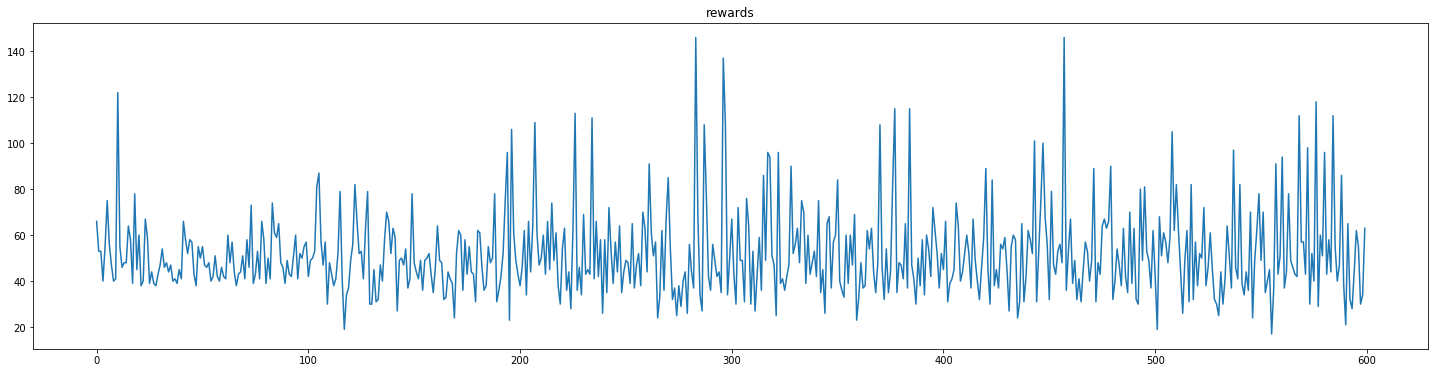

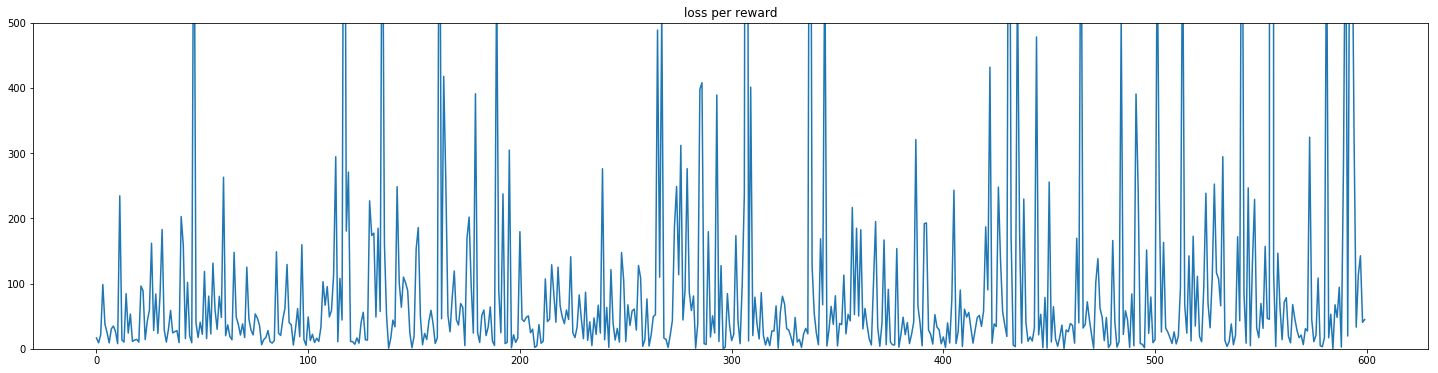

In [17]:
plt.figure(figsize=(25,6))
plt.plot(rewards)
plt.title('rewards')
plt.show()
plt.figure(figsize=(25,6))
plt.plot([loss/reward for loss,reward in zip(losses,rewards)])
plt.title('loss per reward')
plt.ylim(0,500)
plt.show()

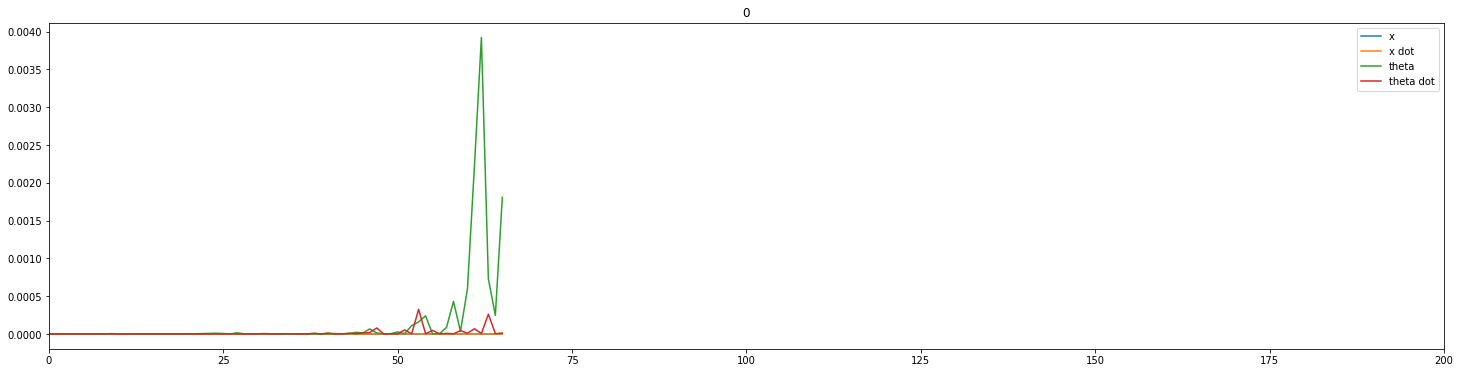

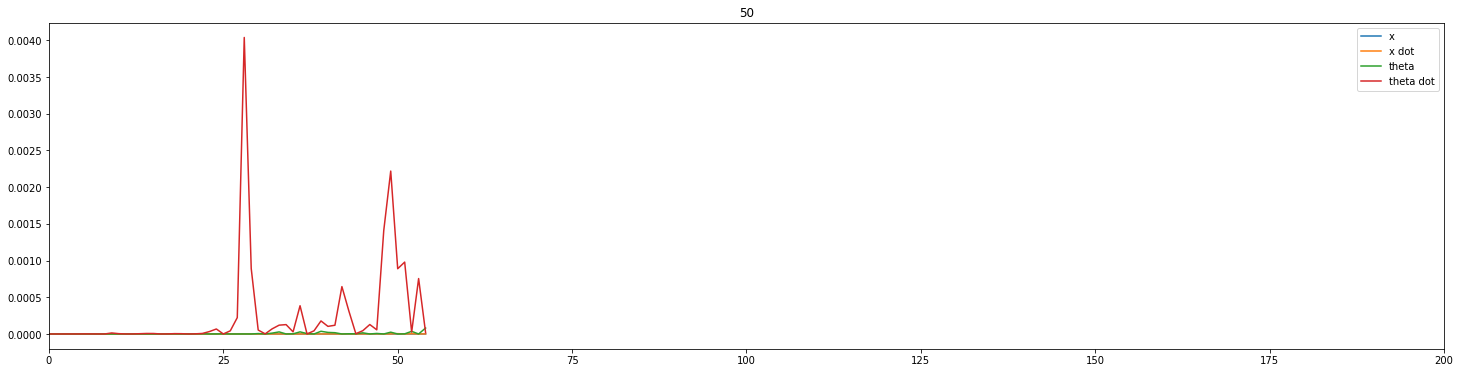

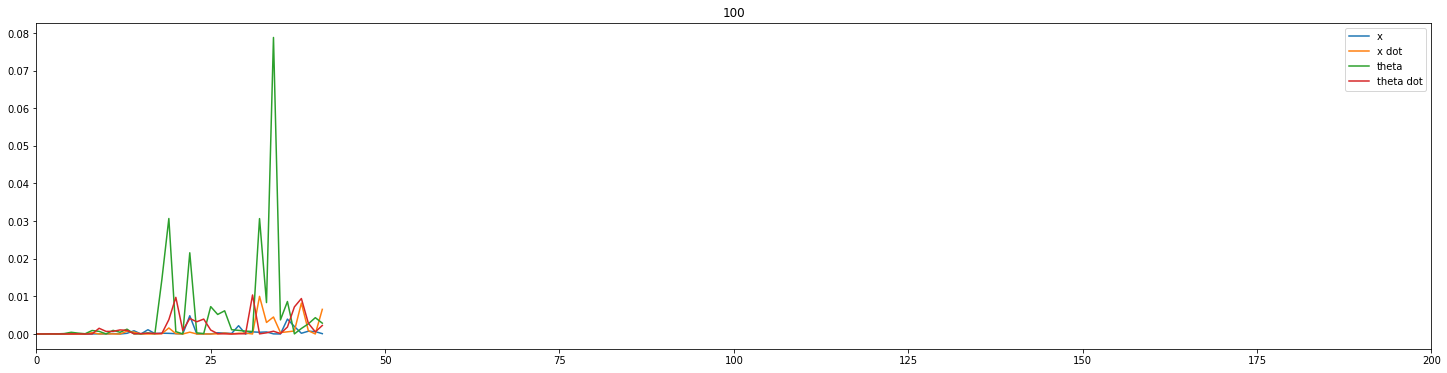

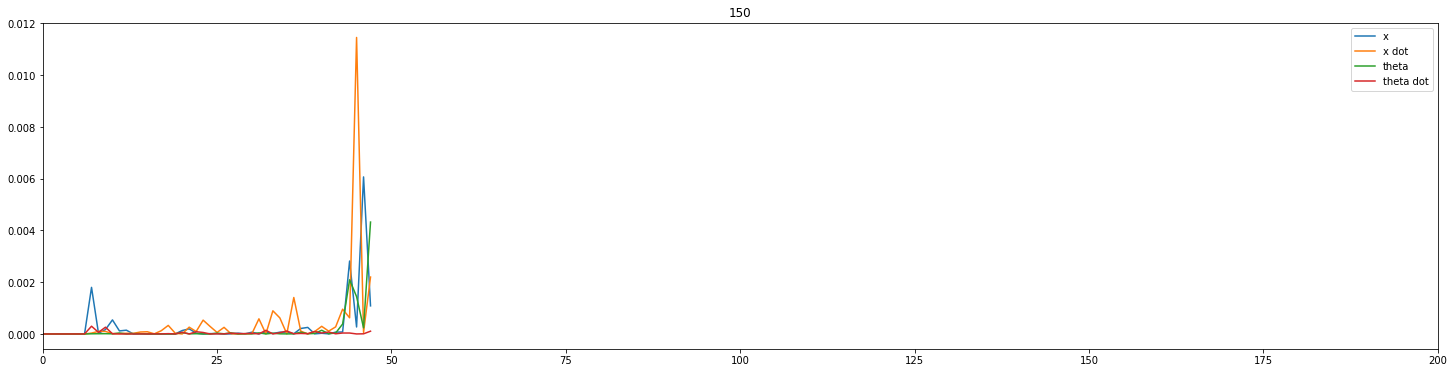

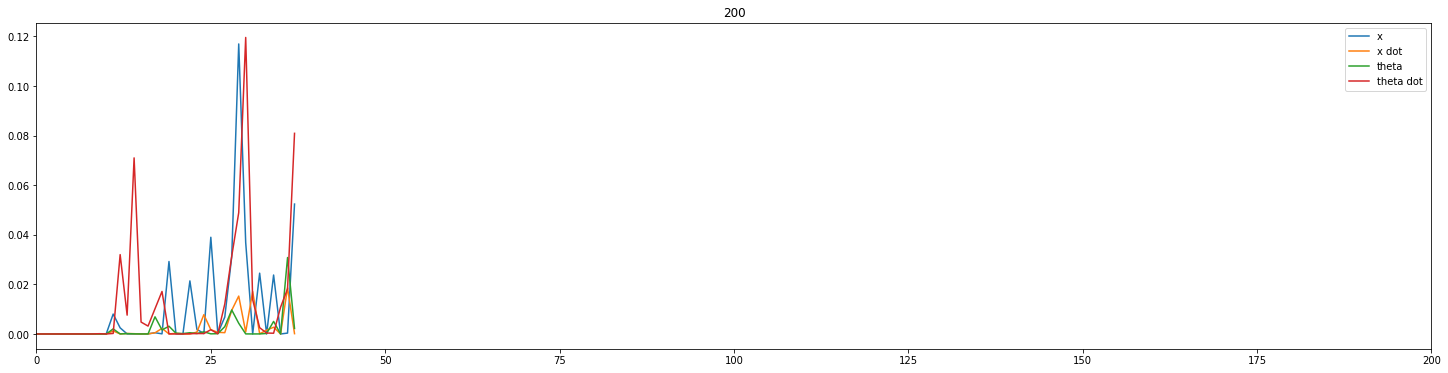

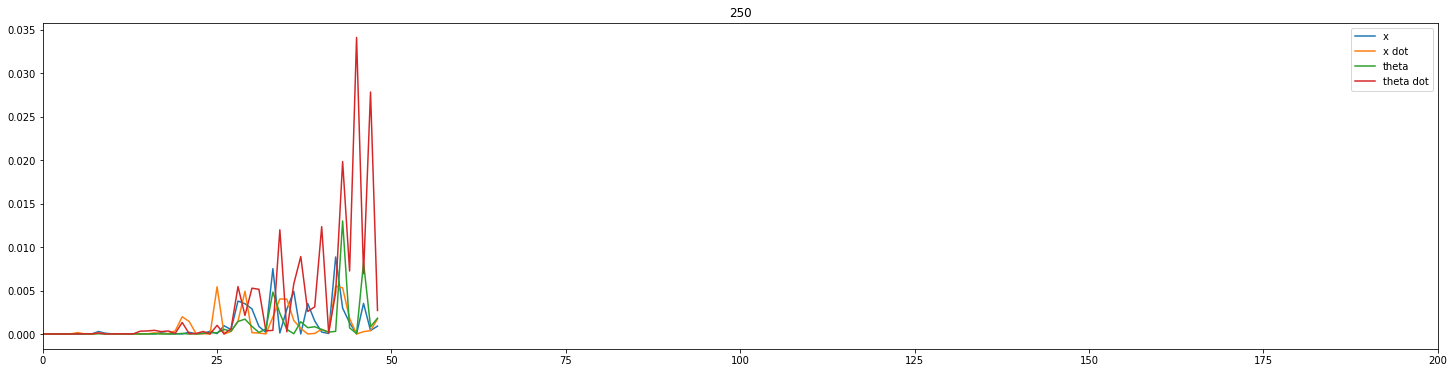

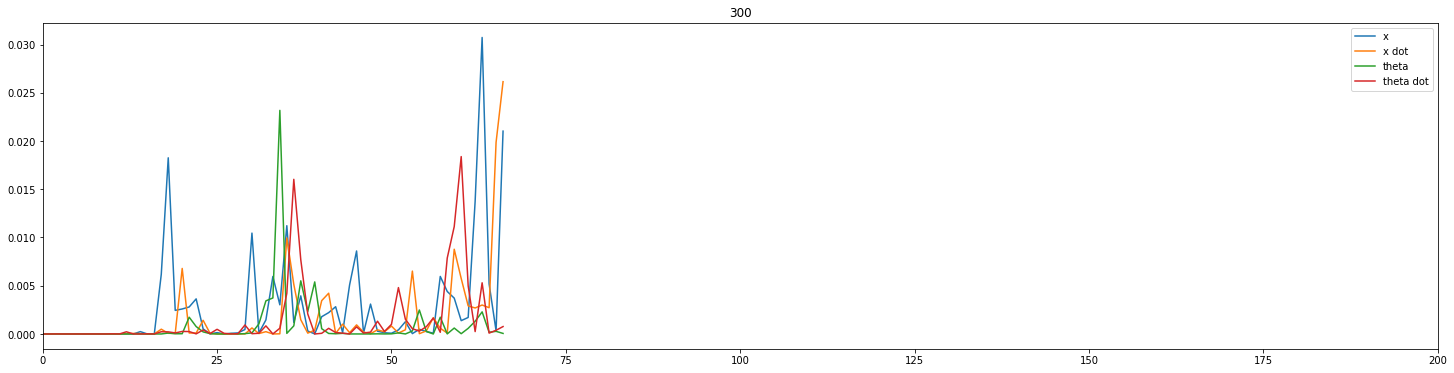

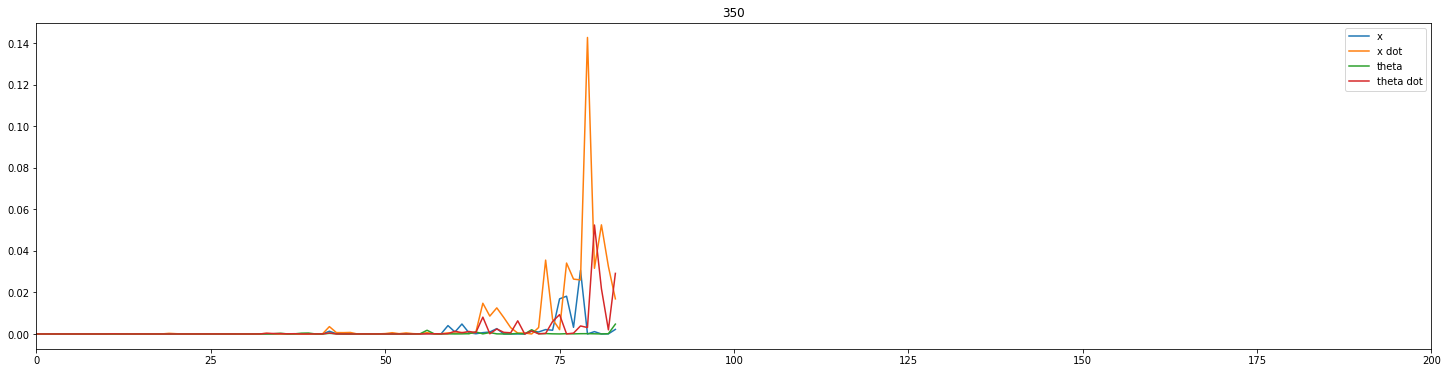

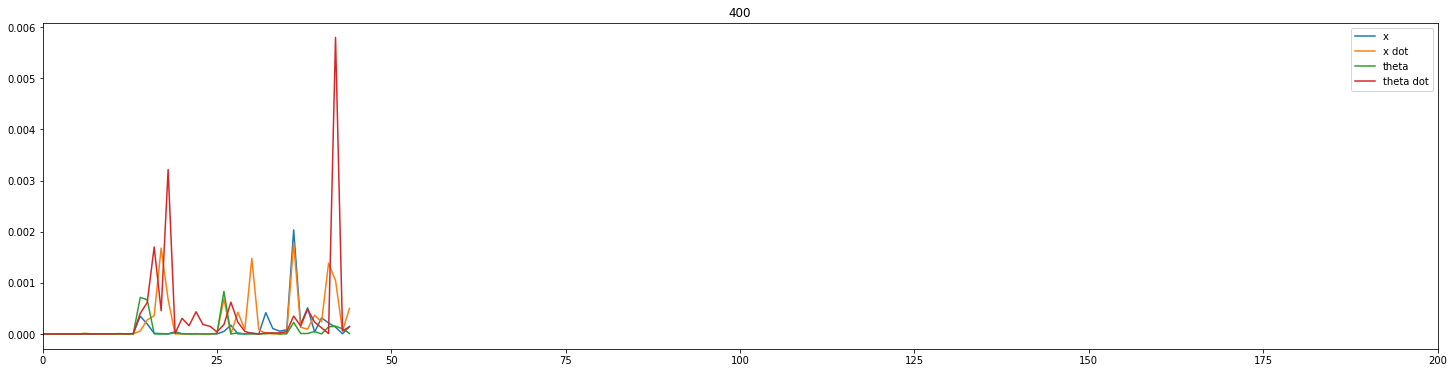

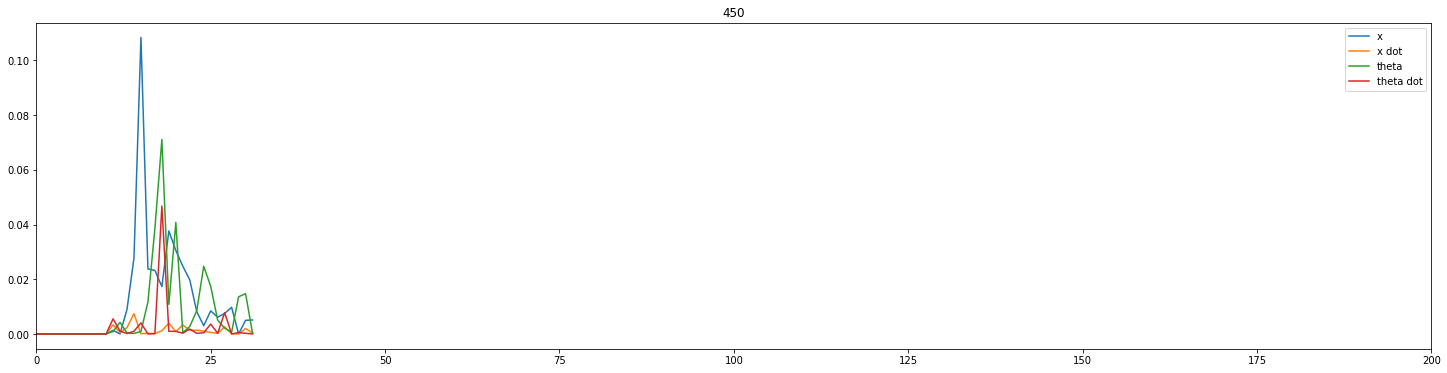

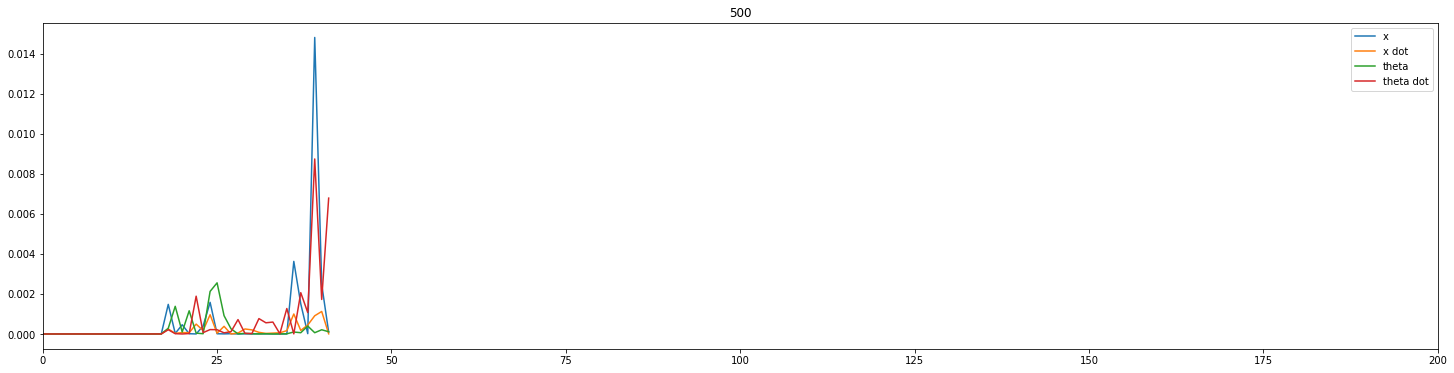

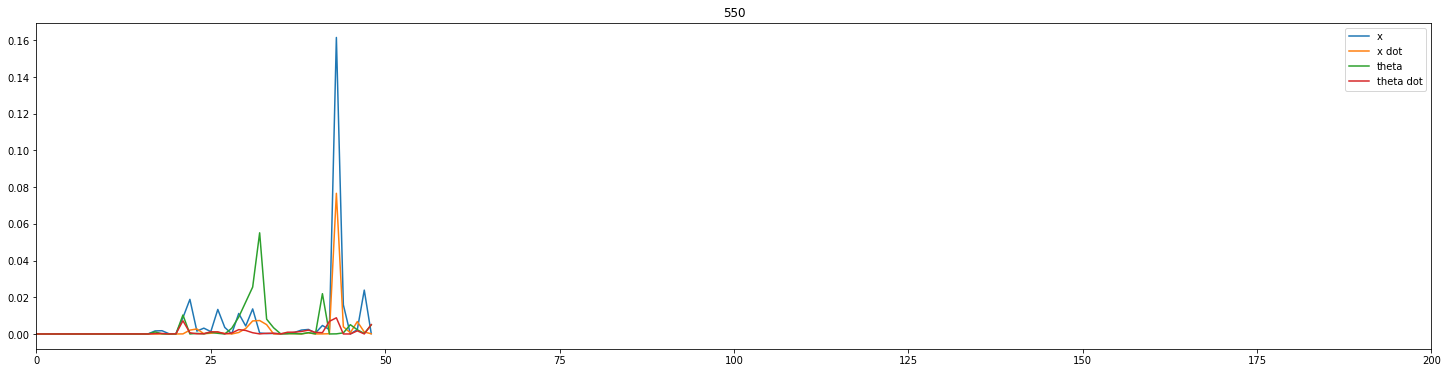

IndexError: index 600 is out of bounds for axis 0 with size 600

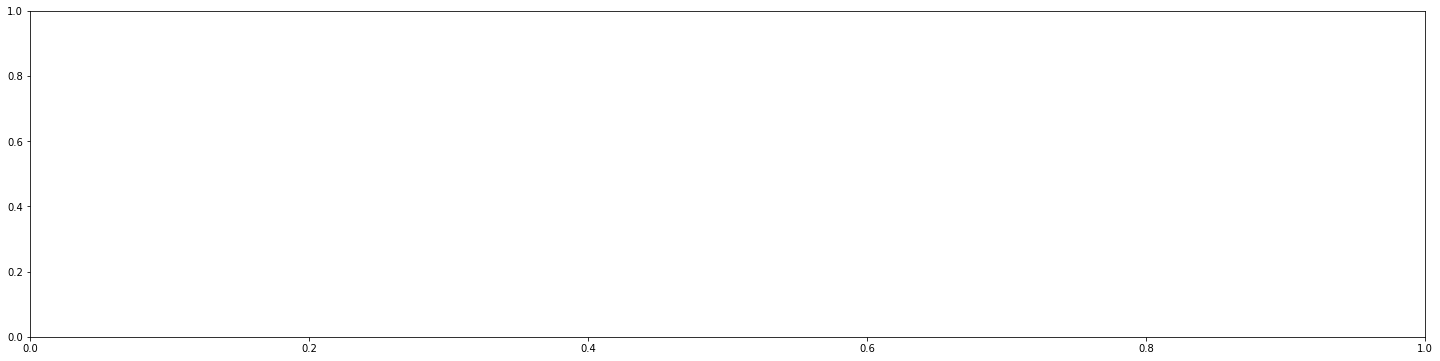

In [15]:
array_squared_errors = np.array(squared_errors)
for i in range(0,1000,50):
    f, ax = plt.subplots(figsize=(25,6))
    ax.plot(array_squared_errors[i][0], label='x')
    ax.plot(array_squared_errors[i][1],label='x dot')
    ax.plot(array_squared_errors[i][2], label = 'theta')
    ax.plot(array_squared_errors[i][3], label = 'theta dot')
    plt.title(i)
    ax.legend()
    ax.set_xlim([0.0,200])
    plt.show()

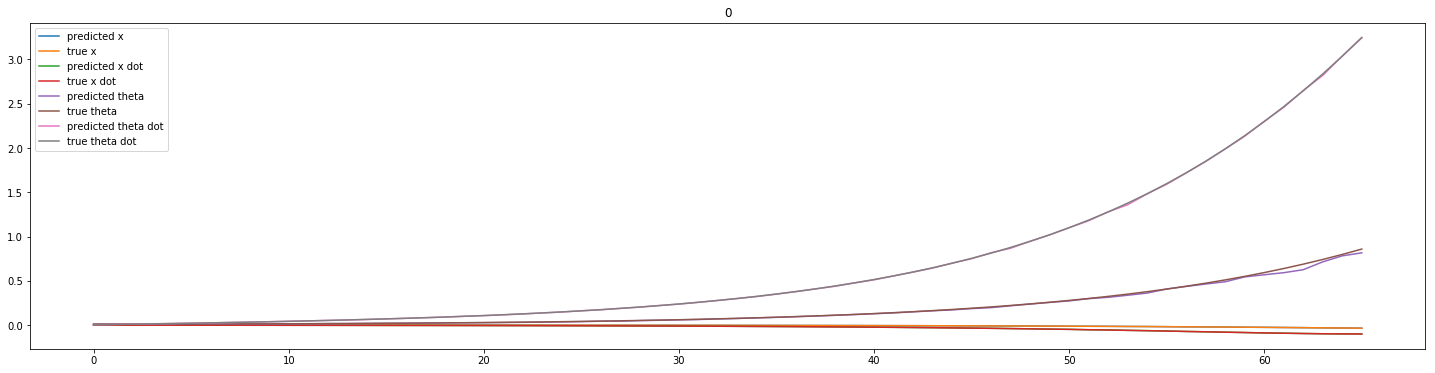

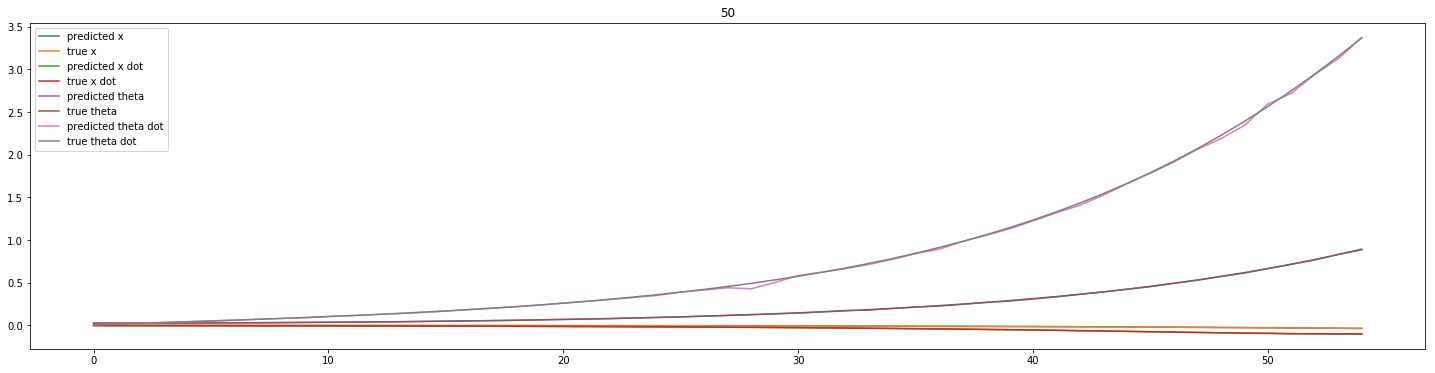

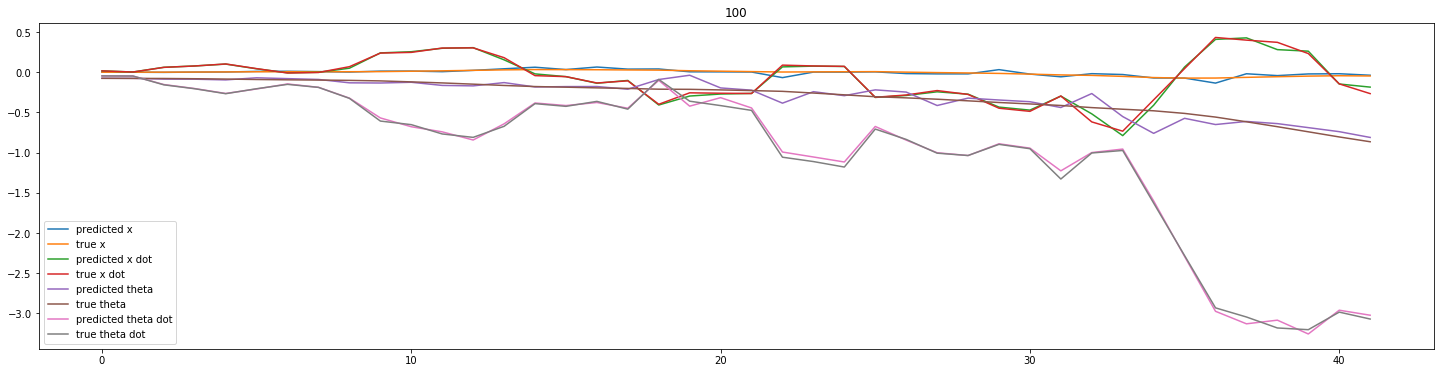

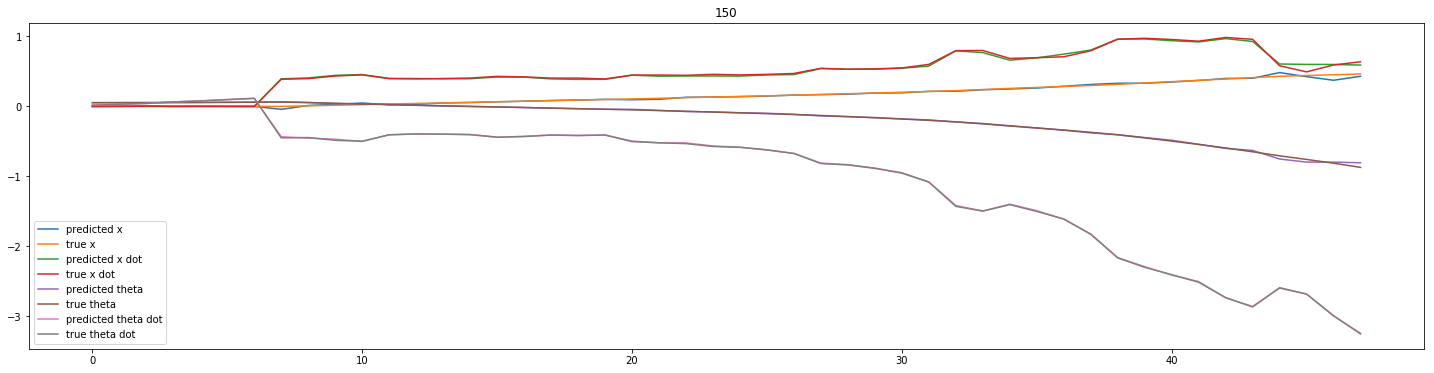

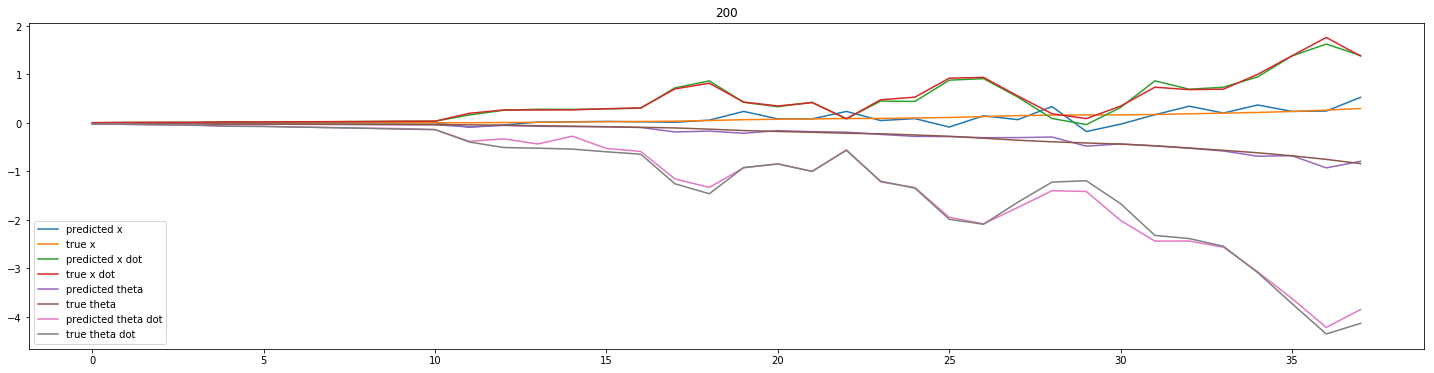

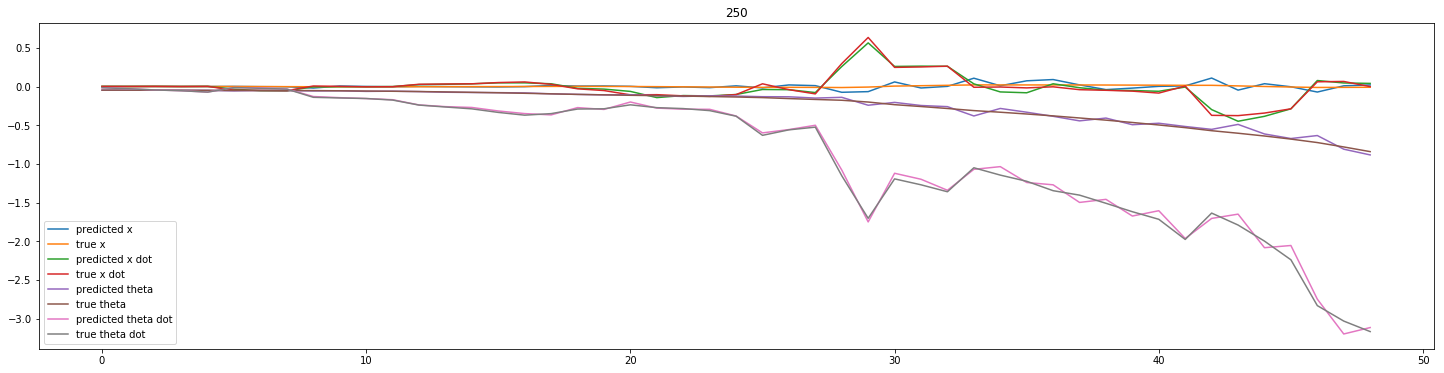

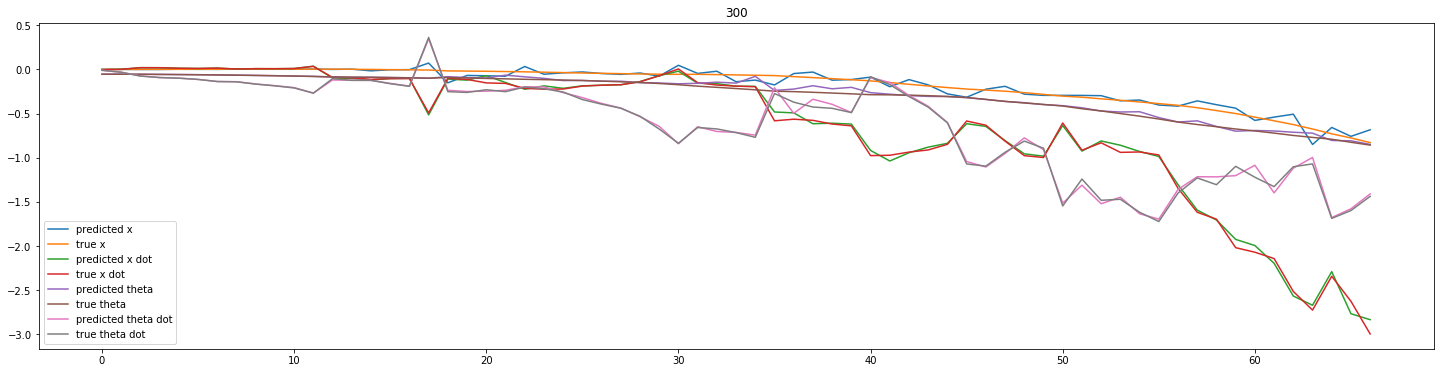

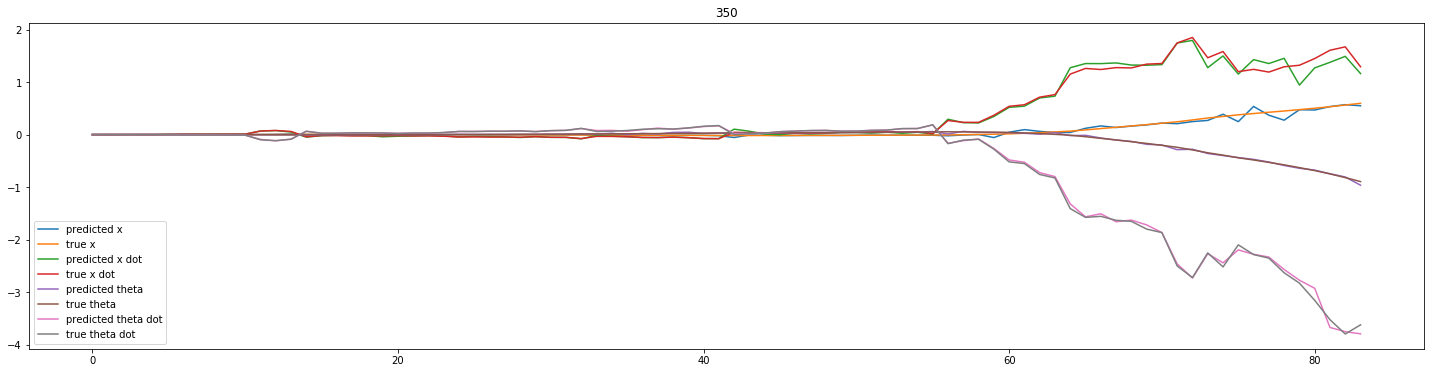

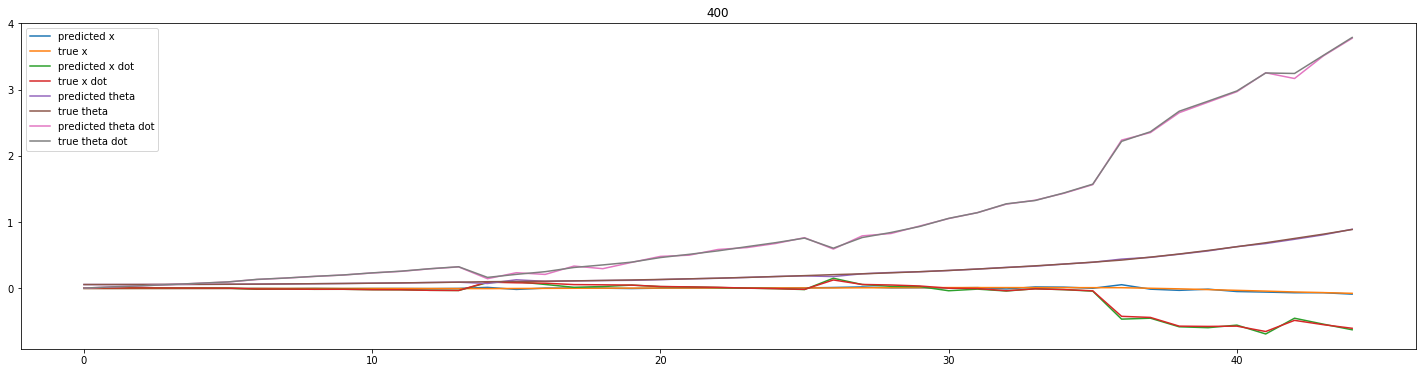

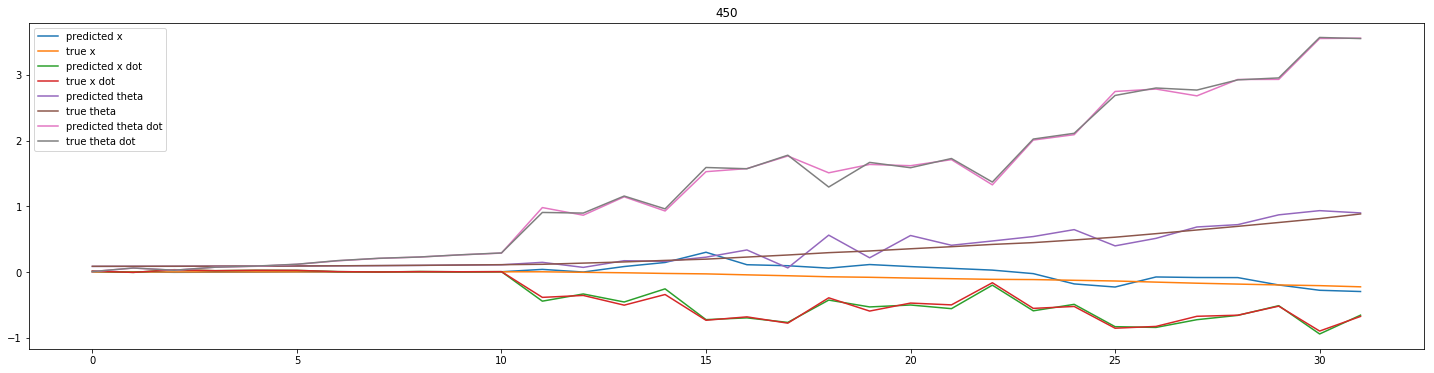

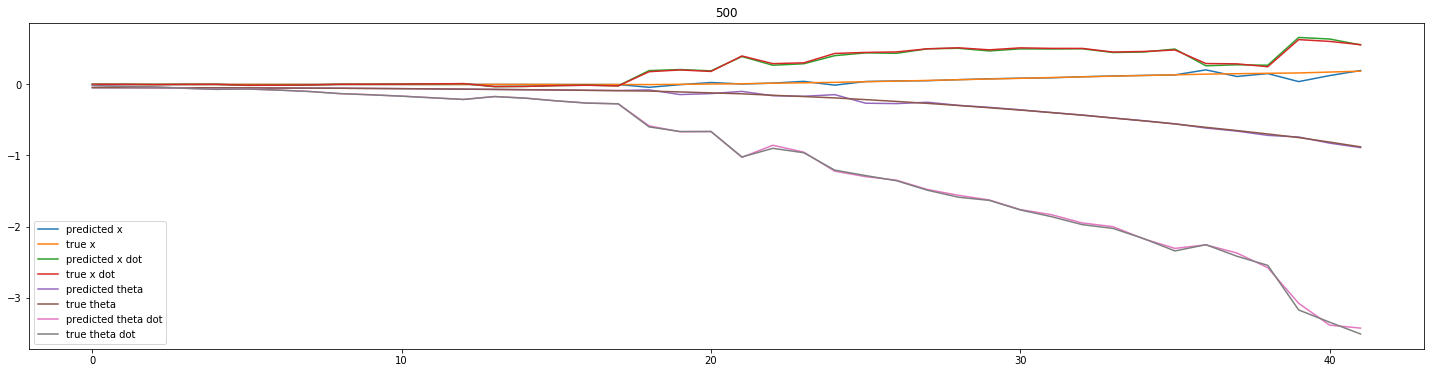

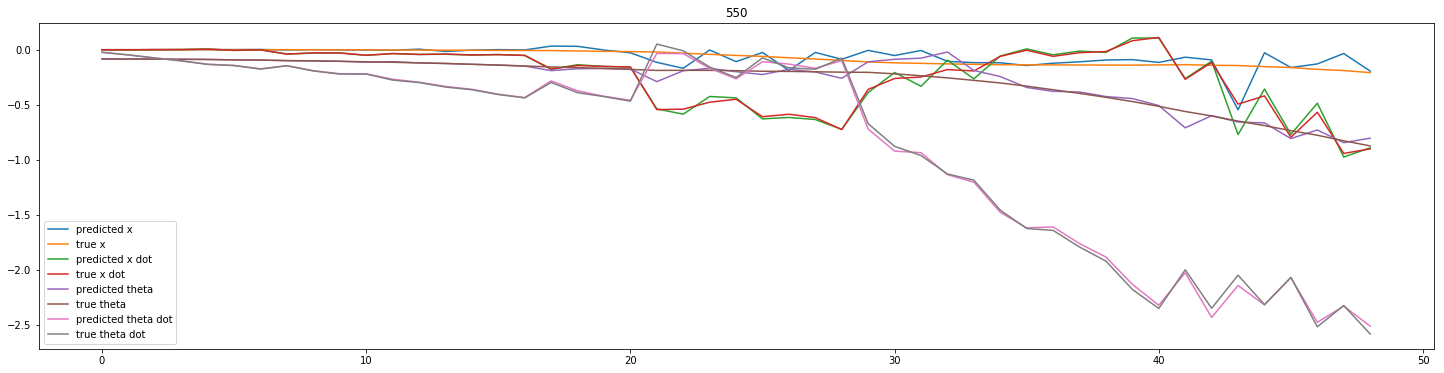

IndexError: index 600 is out of bounds for axis 0 with size 600

<Figure size 1800x432 with 0 Axes>

In [18]:
array_predicted_trajectories = np.array(predicted_trajectories)
array_actual_trajectories = np.array(actual_trajectories)
predictedlabels = ['predicted x', 'predicted x dot', 'predicted theta', 'predicted theta dot']
truelabels = ['true x','true x dot', 'true theta','true theta dot']
for k in range(0,1000,50):
    plt.figure(figsize=(25,6))
    for j in range(4):
        plt.plot(np.squeeze(np.array([array_predicted_trajectories[k][j][i].numpy() for i in range(len(array_predicted_trajectories[k][j]))])), label = predictedlabels[j])
        plt.plot(np.squeeze(np.array([array_actual_trajectories[k][j][i] for i in range(len(array_actual_trajectories[k][j]))])), label = truelabels[j])
#     plt.legend(['x', 'x dot','theta', 'theta dot', 'x', 'x dot','theta', 'theta dot'])
    plt.legend()
    plt.title(k)
    plt.show()